In [ ]:
import sys
del sys.modules['morph_video_with_new_lip_landmarks']

In [1]:
import argparse 
import cv2 
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import tqdm

from scipy.io import loadmat
from skimage.transform import resize

import morph_video_config
from morph_video_with_new_lip_landmarks import *


ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname(os.path.realpath('a.txt')), '../'))
sys.path.append(ROOT_DIR)
import utils

In [2]:
target_video_file = '/shared/fusor/home/voleti.vikram/ANDREW_NG/videos/CV_01_C4W1L01_000003_to_000045/CV_01_C4W1L01_000003_to_000045.mp4'
lip_landmarks_mat_file = '/shared/fusor/home/voleti.vikram/ANDREW_NG/videos/generated_hindi_landmarks/output5/generated_lip_landmarks.mat'
output_video_name = os.path.splitext(target_video_file)[0] + '_with_lips_of_' + os.path.splitext(os.path.basename(lip_landmarks_mat_file))[0] + '_mat.mp4'
generator_model_name = morph_video_config.generator_model
save_faces = True
verbose = True

In [3]:
# Load generator
# generator_model = utils.load_generator(generator_model_name, verbose=verbose)

In [4]:
# _, generator_model_input_rows, generator_model_input_cols, _ = generator_model.layers[0].input_shape
generator_model_input_rows, generator_model_input_cols = 256, 256

In [5]:
mat = loadmat(lip_landmarks_mat_file)
new_lip_landmarks = mat['y_pred']

In [6]:
# Read target video
target_video_reader = imageio.get_reader(target_video_file)
target_video_fps = target_video_reader.get_meta_data()['fps']
if verbose:
    print("target_video_fps:", target_video_fps)

target_video_fps: 30.0


In [7]:
# Note source landmarks
source_lip_landmarks = new_lip_landmarks
num_of_frames = len(source_lip_landmarks)
if verbose:
    print("Number of frames:", num_of_frames)

Number of frames: 241


In [8]:
# Read as many target video frames as source landmarks
target_video_frames = []

if verbose:
    print("Reading target video frames...")

for f, frame in enumerate(target_video_reader):
    target_video_frames.append(frame)
    if f+1 == num_of_frames:
        break

Reading target video frames...


In [9]:
len(target_video_frames)

241

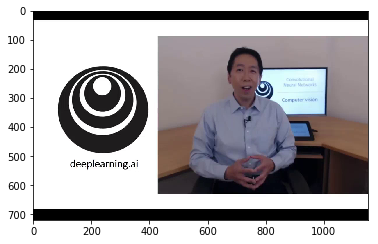

In [10]:
plt.imshow(target_video_frames[0])

In [109]:
# Read target_video_file's frame landmarks
target_all_landmarks_in_frames = read_video_landmarks(video_file_name=target_video_file, read_from_landmarks_file=True, landmarks_type='frames', required_number=num_of_frames, verbose=verbose)

read_video_landmarks: read_from_landmarks_file
read_video_landmarks: Found landmarks file /shared/fusor/home/voleti.vikram/ANDREW_NG/landmarks_in_frames_person/CV_01.C4W1L01_Computer_Vision_landmarks_in_frames_andrew_ng.txt


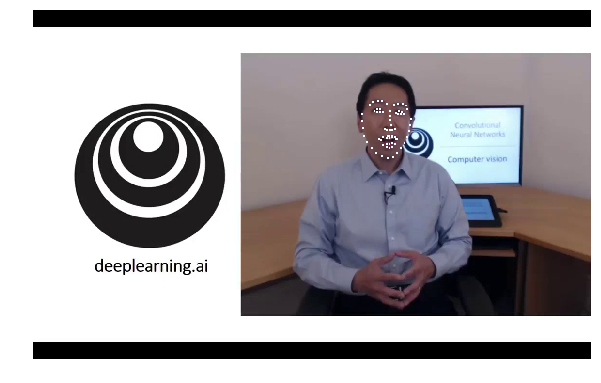

In [12]:
plt.figure(figsize=(10, 15))
utils.plot_2D_landmarks(target_video_frames[0], target_all_landmarks_in_frames[0])
a = plt.axis('off')
# plt.savefig('pilot_frame_with_landmarks.png')

In [13]:
# Make new images of faces with black mouth polygons
face_rect_in_frames = []
face_original_sizes = []
faces_with_black_mouth_polygons = []
M = np.zeros((2, 3))

if verbose:
        print("Making new images of faces with black mouth polygons...")

Making new images of faces with black mouth polygons...


In [99]:
for f, (target_frame, target_all_landmarks_in_frame, source_lip_landmarks_in_frame) in enumerate(tqdm.tqdm(zip(target_video_frames, target_all_landmarks_in_frames, source_lip_landmarks), total=num_of_frames)):

        # Get the face - squared, expanded, resized
        face_square_expanded_resized, \
            landmarks_in_face_square_expanded_resized, \
            face_rect_in_frame, face_original_size = utils.get_square_expand_resize_face_and_modify_landmarks(np.array(target_frame),
                                                                                                              target_all_landmarks_in_frame,
                                                                                                              resize_to_shape=(generator_model_input_rows, generator_model_input_cols),
                                                                                                              face_square_expanded_resized=True)

        # Note face rect in frame, face original size
        face_rect_in_frames.append(face_rect_in_frame)
        face_original_sizes.append(face_original_size)

        # Tx source lip landmarks to good target video position, etc
        target_lip_landmarks_in_frame = landmarks_in_face_square_expanded_resized[48:68]
        # target_lip_landmarks_tx_from_source, M = affine_transform_landmarks(source_lip_landmarks_in_frame, target_lip_landmarks_in_frame, fullAffine=True, prev_M=M)
        target_lip_landmarks_tx_from_source = simple_transform_landmarks(source_lip_landmarks_in_frame, target_lip_landmarks_in_frame)

        # Make face with black mouth polygon
        face_with_bmp = utils.make_black_mouth_and_lips_polygons(face_square_expanded_resized, target_lip_landmarks_tx_from_source)
        faces_with_black_mouth_polygons.append(face_with_bmp)
        
        break

  0%|          | 0/241 [00:00<?, ?it/s]


In [100]:
target_lip_landmarks_tx_from_source

array([[109, 159],
       [120, 150],
       [130, 145],
       [138, 149],
       [146, 144],
       [155, 150],
       [163, 159],
       [155, 175],
       [146, 182],
       [138, 184],
       [129, 183],
       [119, 176],
       [114, 160],
       [130, 158],
       [138, 159],
       [146, 157],
       [159, 160],
       [146, 162],
       [137, 164],
       [129, 162]])

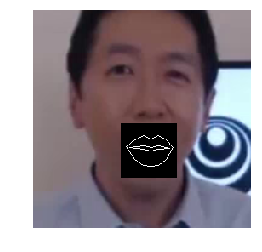

In [101]:
plt.imshow(faces_with_black_mouth_polygons[0]); a = plt.axis('off')

In [16]:
# imageio.imwrite('pilot_face_with_bmp.png', face_with_bmp)

In [17]:
# Predict new faces using generator
if verbose:
    print("Generating new faces using faces_with_bmp...")

# new_faces = utils.unnormalize_output_from_generator(generator_model.predict(utils.normalize_input_to_generator(faces_with_black_mouth_polygons)))
new_faces = [imageio.imread('pilot_gen_face.png')]

Generating new faces using faces_with_bmp...


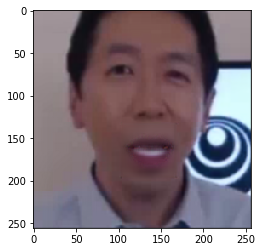

In [18]:
plt.imshow(new_faces[0])

In [19]:
new_frames = np.array(target_video_frames)
for f, (new_frame, new_face, face_original_size, face_rect_in_frame) in enumerate(tqdm.tqdm(zip(new_frames, new_faces, face_original_sizes, face_rect_in_frames), total=num_of_frames)):
    new_face_resized = np.round(resize(new_face, face_original_size, mode='reflect', preserve_range=True)).astype('uint8')
    left, top, right, bottom = face_rect_in_frame[0], face_rect_in_frame[1], face_rect_in_frame[2], face_rect_in_frame[3]
    new_frames[f][face_rect_in_frame[1]:face_rect_in_frame[3], face_rect_in_frame[0]:face_rect_in_frame[2]] = new_face_resized

  0%|          | 1/241 [00:00<00:04, 57.04it/s]


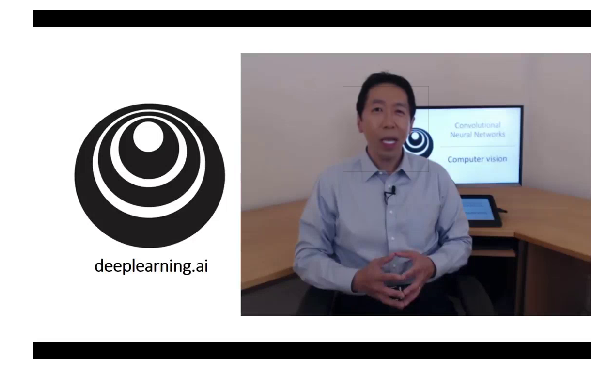

In [20]:
plt.figure(figsize=(10, 15))
plt.imshow(new_frames[0])
a = plt.axis('off')

In [98]:
def simple_transform_landmarks(source_landmarks, target_landmarks):

    source_landmarks = source_landmarks.astype('float')
    target_landmarks = target_landmarks.astype('float')
    
    # Mouth left corner
    ml_source = source_landmarks[0]
    ml_target = target_landmarks[0]

    # Mouth right corner
    mr_source = source_landmarks[6]
    mr_target = target_landmarks[6]

    # Mouth top
    mt_source = source_landmarks[3]
    mt_target = target_landmarks[3]

    # Mouth bottom
    mb_source = source_landmarks[9]
    mb_target = target_landmarks[9]

    # Centroid
    mouth_centroid_source = (ml_source + mr_source + mt_source + mb_source)/4
    mouth_centroid_target = (ml_target + mr_target + mt_target + mb_target)/4

    # Centre both mouths
    mouth_centred_source = source_landmarks - mouth_centroid_source
    mouth_centred_target = target_landmarks - mouth_centroid_target

    # Calculate scales
    scale_x = (mr_target - ml_target)[0]/(mr_source - ml_source)[0]
    scale_y = (mt_target - mb_target)[1]/(mt_source - mb_source)[1]
    # print(scale_x, scale_y)

    # Scale the source centred landmarks
    mouth_centred_source[:, 0] = mouth_centred_source[:, 0] * scale_x
    mouth_centred_source[:, 1] = mouth_centred_source[:, 1] * scale_y

    # Centre it to the target centre
    new_mouth_landmarks = mouth_centred_source + mouth_centroid_target

    return np.round(new_mouth_landmarks).astype('int')

In [82]:
new_mouth_landmarks

array([[109.28892885, 159.18880219],
       [119.66653949, 150.28789045],
       [129.64836865, 144.65849204],
       [137.79697638, 149.01589323],
       [145.97809537, 144.40930888],
       [154.96295629, 149.86313955],
       [163.28892885, 158.77941134],
       [155.14172827, 174.53345092],
       [146.37171451, 182.04983444],
       [137.62516592, 184.01589323],
       [128.89890689, 182.79276032],
       [119.17981047, 175.81467142],
       [113.84572615, 160.16016801],
       [129.53748145, 157.67722646],
       [137.76771069, 159.44142443],
       [146.11955271, 157.36067275],
       [158.89367084, 159.80957005],
       [145.88749127, 161.72568911],
       [137.45897211, 164.34819759],
       [129.26353965, 162.45727686]])

In [81]:
target_landmarks

array([[108., 159.],
       [120., 152.],
       [133., 148.],
       [139., 149.],
       [146., 148.],
       [156., 152.],
       [162., 159.],
       [156., 174.],
       [146., 182.],
       [139., 184.],
       [130., 182.],
       [119., 175.],
       [113., 161.],
       [132., 155.],
       [139., 155.],
       [146., 153.],
       [159., 159.],
       [146., 171.],
       [139., 172.],
       [132., 172.]])

In [65]:
target_lip_landmarks_tx_from_source = simple_transform_landmarks(source_lip_landmarks_in_frame, target_lip_landmarks_in_frame)

In [104]:
source_lip_landmarks_in_frame.shape

(20, 2)

In [110]:
target_all_landmarks_in_frames[0]

array([[679., 214.],
       [679., 229.],
       [681., 244.],
       [684., 259.],
       [690., 272.],
       [699., 284.],
       [709., 295.],
       [720., 302.],
       [732., 305.],
       [743., 303.],
       [752., 295.],
       [760., 285.],
       [767., 274.],
       [772., 262.],
       [776., 249.],
       [779., 237.],
       [780., 224.],
       [696., 196.],
       [702., 189.],
       [712., 187.],
       [721., 188.],
       [730., 193.],
       [746., 196.],
       [754., 193.],
       [763., 193.],
       [770., 197.],
       [773., 205.],
       [738., 208.],
       [738., 218.],
       [738., 227.],
       [739., 237.],
       [726., 245.],
       [731., 247.],
       [737., 248.],
       [742., 247.],
       [747., 246.],
       [705., 208.],
       [710., 205.],
       [717., 205.],
       [722., 210.],
       [716., 211.],
       [710., 210.],
       [749., 213.],
       [755., 209.],
       [761., 210.],
       [765., 214.],
       [760., 215.],
       [754.,

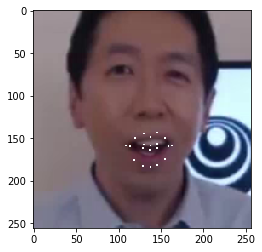

In [112]:
utils.plot_2D_landmarks(face_square_expanded_resized, target_lip_landmarks_tx_from_source)

In [108]:
target_lip_landmarks_in_frame

array([[108, 159],
       [120, 152],
       [133, 148],
       [139, 149],
       [146, 148],
       [156, 152],
       [162, 159],
       [156, 174],
       [146, 182],
       [139, 184],
       [130, 182],
       [119, 175],
       [113, 161],
       [132, 155],
       [139, 155],
       [146, 153],
       [159, 159],
       [146, 171],
       [139, 172],
       [132, 172]])

In [69]:
source_lip_landmarks_in_frame

array([[-7.10926798e-02, -3.58978912e-03],
       [-4.51757408e-02, -1.54135795e-02],
       [-2.02472225e-02, -2.28915579e-02],
       [ 1.03027317e-04, -1.71032747e-02],
       [ 2.05344704e-02, -2.32225678e-02],
       [ 4.29731705e-02, -1.59778099e-02],
       [ 6.37663694e-02, -4.13361561e-03],
       [ 4.34196338e-02,  1.67937305e-02],
       [ 2.15174909e-02,  2.67783417e-02],
       [-3.26050366e-04,  2.93900142e-02],
       [-2.21189207e-02,  2.77652293e-02],
       [-4.63912929e-02,  1.84956778e-02],
       [-5.97125807e-02, -2.29944651e-03],
       [-2.05241511e-02, -5.59773561e-03],
       [ 2.99394913e-05, -3.25421088e-03],
       [ 2.08877446e-02, -6.01823914e-03],
       [ 5.27896969e-02, -2.76517371e-03],
       [ 2.03081967e-02, -2.19840077e-04],
       [-7.41101099e-04,  3.26384690e-03],
       [-2.12082905e-02,  7.51986229e-04]])

In [70]:
target_lip_landmarks_in_frame = landmarks_in_face_square_expanded_resized[48:68]

In [71]:
target_lip_landmarks_in_frame

array([[108, 159],
       [120, 152],
       [133, 148],
       [139, 149],
       [146, 148],
       [156, 152],
       [162, 159],
       [156, 174],
       [146, 182],
       [139, 184],
       [130, 182],
       [119, 175],
       [113, 161],
       [132, 155],
       [139, 155],
       [146, 153],
       [159, 159],
       [146, 171],
       [139, 172],
       [132, 172]])

In [72]:
source_landmarks = np.array(source_lip_landmarks_in_frame).astype('float')
target_landmarks = np.array(target_lip_landmarks_in_frame).astype('float')

# Mouth left corner
ml_source = source_landmarks[0]
ml_target = target_landmarks[0]

# Mouth right corner
mr_source = source_landmarks[6]
mr_target = target_landmarks[6]

# Mouth top
mt_source = source_landmarks[3]
mt_target = target_landmarks[3]

# Mouth bottom
mb_source = source_landmarks[9]
mb_target = target_landmarks[9]

In [73]:
ml_target

array([108., 159.])

In [74]:
# Centroid
mouth_centroid_source = (ml_source + mr_source + mt_source + mb_source)/4
mouth_centroid_target = (ml_target + mr_target + mt_target + mb_target)/4

# Centre both mouths
mouth_centred_source = source_landmarks - mouth_centroid_source
mouth_centred_target = target_landmarks - mouth_centroid_target

In [75]:
mouth_centred_source

array([[-0.06920535, -0.00473062],
       [-0.04328841, -0.01655441],
       [-0.01835989, -0.02403239],
       [ 0.00199036, -0.01824411],
       [ 0.0224218 , -0.0243634 ],
       [ 0.0448605 , -0.01711864],
       [ 0.0656537 , -0.00527445],
       [ 0.04530697,  0.0156529 ],
       [ 0.02340482,  0.02563751],
       [ 0.00156128,  0.02824918],
       [-0.02023159,  0.0266244 ],
       [-0.04450396,  0.01735484],
       [-0.05782525, -0.00344028],
       [-0.01863682, -0.00673857],
       [ 0.00191727, -0.00439504],
       [ 0.02277508, -0.00715907],
       [ 0.05467703, -0.00390601],
       [ 0.02219553, -0.00136067],
       [ 0.00114623,  0.00212301],
       [-0.01932096, -0.00038885]])

In [76]:
mouth_centred_target

array([[-29.  ,  -3.75],
       [-17.  , -10.75],
       [ -4.  , -14.75],
       [  2.  , -13.75],
       [  9.  , -14.75],
       [ 19.  , -10.75],
       [ 25.  ,  -3.75],
       [ 19.  ,  11.25],
       [  9.  ,  19.25],
       [  2.  ,  21.25],
       [ -7.  ,  19.25],
       [-18.  ,  12.25],
       [-24.  ,  -1.75],
       [ -5.  ,  -7.75],
       [  2.  ,  -7.75],
       [  9.  ,  -9.75],
       [ 22.  ,  -3.75],
       [  9.  ,   8.25],
       [  2.  ,   9.25],
       [ -5.  ,   9.25]])

In [77]:
# Calculate scales
scale_x = (mr_target - ml_target)[0]/(mr_source - ml_source)[0]
scale_y = (mt_target - mb_target)[1]/(mt_source - mb_source)[1]
print(scale_x, scale_y)

# Scale the source centred landmarks
mouth_centred_source[:, 0] = mouth_centred_source[:, 0] * scale_x
mouth_centred_source[:, 1] = mouth_centred_source[:, 1] * scale_y

400.41806850274855 752.7968184145373


In [78]:
mouth_centred_source

array([[-27.71107115,  -3.56119781],
       [-17.33346051, -12.46210955],
       [ -7.35163135, -18.09150796],
       [  0.79697638, -13.73410677],
       [  8.97809537, -18.34069112],
       [ 17.96295629, -12.88686045],
       [ 26.28892885,  -3.97058866],
       [ 18.14172827,  11.78345092],
       [  9.37171451,  19.29983444],
       [  0.62516592,  21.26589323],
       [ -8.10109311,  20.04276032],
       [-17.82018953,  13.06467142],
       [-23.15427385,  -2.58983199],
       [ -7.46251855,  -5.07277354],
       [  0.76771069,  -3.30857557],
       [  9.11955271,  -5.38932725],
       [ 21.89367084,  -2.94042995],
       [  8.88749127,  -1.02431089],
       [  0.45897211,   1.59819759],
       [ -7.73646035,  -0.29272314]])

In [79]:
# Centre it to the target centre
new_mouth_landmarks = mouth_centred_source + mouth_centroid_target

In [80]:
new_mouth_landmarks

array([[109.28892885, 159.18880219],
       [119.66653949, 150.28789045],
       [129.64836865, 144.65849204],
       [137.79697638, 149.01589323],
       [145.97809537, 144.40930888],
       [154.96295629, 149.86313955],
       [163.28892885, 158.77941134],
       [155.14172827, 174.53345092],
       [146.37171451, 182.04983444],
       [137.62516592, 184.01589323],
       [128.89890689, 182.79276032],
       [119.17981047, 175.81467142],
       [113.84572615, 160.16016801],
       [129.53748145, 157.67722646],
       [137.76771069, 159.44142443],
       [146.11955271, 157.36067275],
       [158.89367084, 159.80957005],
       [145.88749127, 161.72568911],
       [137.45897211, 164.34819759],
       [129.26353965, 162.45727686]])

In [33]:
target_lip_landmarks_tx_from_source

array([[198, 249],
       [221, 233],
       [244, 223],
       [  3, 229],
       [ 18, 223],
       [ 38, 232],
       [ 53, 248],
       [ 38,  23],
       [ 19,  39],
       [  3,  42],
       [241,  39],
       [219,  25],
       [208, 252],
       [243, 243],
       [  3, 245],
       [ 19, 241],
       [ 45, 249],
       [ 18,   7],
       [  2,  11],
       [243,   9]], dtype=uint8)

In [62]:
target_lip_landmarks_tx_from_source

array([[ 85, 161],
       [104, 156],
       [123, 153],
       [138, 155],
       [154, 153],
       [171, 156],
       [186, 161],
       [171, 169],
       [155, 173],
       [138, 174],
       [122, 173],
       [103, 170],
       [ 93, 161],
       [123, 160],
       [138, 161],
       [154, 160],
       [178, 161],
       [154, 162],
       [138, 164],
       [122, 163]], dtype=uint8)

In [ ]:
#####################################################
# morph_video_config.py
#####################################################

generator_model = '/shared/fusor/home/voleti.vikram/DeepLearningImplementations/pix2pix/models/20180414_015206_andrew_ng/generator_latest.h5'
dataset_dir = '/shared/fusor/home/voleti.vikram/ANDREW_NG'
person = 'andrew_ng'

#####################################################
# morph_video_with_new_lip_landmarks.py
#####################################################

import argparse
import cv2
import glob
import imageio
import numpy as np
import os
import sys
import time
import tqdm

from scipy.io import loadmat
from skimage.transform import resize

import morph_video_config

ROOT_DIR = os.path.realpath(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../'))
sys.path.append(ROOT_DIR)
import utils


def read_video_landmarks(video_file_name=None, video_frames=None,
                         read_from_landmarks_file=True, landmarks_type='frames',
                         dataset_dir=morph_video_config.dataset_dir, person=morph_video_config.person,
                         required_number=None, verbose=False):
    """
    Read landmarks
    1) from files with landmarks in full frames like /shared/fusor/home/voleti.vikram/ANDREW_NG/landmarks_in_frames_person/CV_01.C4W1L01_Computer_Vision_in_frames_andrew_ng.txt,
    => read_from_landmarks_file=True, landmarks_type='frames', video_file_name is REQUIRED
    2) from files with landmarks in face images, like shared/fusor/home/voleti.vikram/ANDREW_NG/landmarks_in_faces_person/CV_01.C4W1L01_Computer_Vision_in_faces_andrew_ng.txt
    => read_from_landmarks_file=True, landmarks_type='faces', video_file_name is REQUIRED
    3) from the frames themselves (detect faces and predict landmarks using dlib)
    => read_from_landmarks_file=False, video_frames is REQUIRED
    """

    if read_from_landmarks_file:

        if verbose:
            print("read_video_landmarks: read_from_landmarks_file")

        if video_file_name == None:
            raise ValueError("ERROR: read_video_frame_landmarks: video_file_name needs to be given, since read_from_landmarks_file=True!")

        if not os.path.exists(dataset_dir):
            raise ValueError("ERROR: dataset_dir does not exist! Given:" + dataset_dir)
   
        if landmarks_type == 'frames': 
            landmarks_dir = os.path.join(dataset_dir, 'landmarks_in_frames_person')
        elif landmarks_type == 'faces':
            landmarks_dir = os.path.join(dataset_dir, 'landmarks_in_faces_person')    
        else:
            raise ValueError("ERROR: landmarks_type can only be 'frames' or 'faces'! Given:" + landmarks_type)

        if not os.path.exists(landmarks_dir):
            raise ValueError("ERROR: landmarks_in_frames_person_dir not not exist! Given:" + landmarks_in_frames_person_dir)
    
        # Read all landmarks files
        landmarks_files = sorted(glob.glob(os.path.join(landmarks_dir, '*.txt')))
    
        # Get the right landmark_file by checking for video_file_name_checks in each landmark_file
        video_file_name_checks = os.path.basename(video_file_name).split('_')[:3] + [person]
        for landmarks_file in landmarks_files:
            this_one = True
            for video_file_name_check in video_file_name_checks:
                if video_file_name_check in landmarks_file:
                    this_one = this_one & True
                else:
                    this_one = this_one & False
            if this_one:
                break

        if not this_one:
            raise ValueError("ERROR: could not find any landmarks file for the video_file_name" + video_file_name)

        if verbose:
            print("read_video_landmarks: Found landmarks file", landmarks_file)

        # Read all landmarks of all frames of video_file_name
        landmarks_full = utils.read_landmarks_list_from_txt(landmarks_file)

        # Note only those landmarks of the required number of frames
        if required_number is not None:
            landmarks_full = landmarks_full[:required_number]

        # Save only mouth landmarks
        landmarks = np.array([lms[1:] for lms in landmarks_full]).astype('float')

        return landmarks

    else:

        if video_frames == None:
            raise ValueError("ERROR: read_video_frame_landmarks: video_frames needs to be given, since read_from_landmarks_file=False!")

        print("read_video_frame_landmarks: detecting faces and predicting landmarks in every frame...")

        dlib_face_detector, dlib_shape_predictor = load_dlib_detector_and_predictor(verbose=verbose)

        landmarks = []
        for frame in tqdm.tqdm(video_frames):
            landmarks_in_frame = get_landmarks_using_dlib_detector_and_predictor(frame, dlib_face_detector, dlib_shape_predictor)
            landmarks.append(landmarks_in_frame[1:])

        return np.array(landmarks)


def getOriginalKeypoints(kp_features_mouth, N, tilt, mean):
    # Denormalize the points
    kp_dn = N * kp_features_mouth
    # Add the tilt
    x, y = kp_dn[:, 0], kp_dn[:, 1]
    c, s = np.cos(tilt), np.sin(tilt)
    x_dash, y_dash = x*c + y*s, -x*s + y*c
    kp_tilt = np.hstack((x_dash.reshape((-1,1)), y_dash.reshape((-1,1))))
    # Shift to the mean
    kp = kp_tilt + mean
    return kp


def affine_transform_landmarks_abhishek(source_landmarks, target_landmarks):
    source_landmarks_tx_to_target = []
    for idx, (source_landmarks_per_frame, t) in enumerate(zip(source_landmarks, target_landmarks)):
        target_lip_landmarks_normalized, target_N, target_tilt, target_mean, target_all_landmarks_normalized, target_all_landmarks = k[0], k[1], k[2], k[3], k[4], k[5]
        kps = getOriginalKeypoints(source_landmarks_per_frame, target_N, target_tilt, target_mean)
        source_landmarks_mapped_to_target.append(kps)
    return source_landmarks_tx_to_target


def affine_transform_landmarks(source_landmarks, target_landmarks, fullAffine=True, prev_M=np.zeros((2, 3))):
    M = cv2.estimateRigidTransform(source_landmarks.astype('float'), target_landmarks.astype('float'), fullAffine)
    if M is None:
        M = prev_M
    target_landmarks_tx_from_source = np.round( np.dot( M, np.hstack(( source_landmarks, np.ones((len(source_landmarks), 1)) )).T ).T ).astype('int')
    return target_landmarks_tx_from_source, M


def tmp_morph_video_with_new_lip_landmarks(generator_model, target_video_file, target_audio_file, lip_landmarks_mat_file, output_video_name, save_faces=False, verbose=False):

    # Read predicted lip landmarks    
    mat = loadmat(lip_landmarks_mat_file)
    new_lip_landmarks = mat['y_pred']

    # Call the actual function
    morph_video_with_new_lip_landmarks(generator_model, target_video_file, target_audio_file, new_lip_landmarks, output_video_name, save_faces, verbose)


def morph_video_with_new_lip_landmarks(generator_model, target_video_file, target_audio_file, new_lip_landmarks, output_video_name, save_faces=False, verbose=False):

    # Generator model input shape
    _, generator_model_input_rows, generator_model_input_cols, _ = generator_model.layers[0].input_shape
    if verbose:
        print("generator_model input shape:", (generator_model_input_rows, generator_model_input_cols))

    # Read target video
    target_video_reader = imageio.get_reader(target_video_file)
    target_video_fps = target_video_reader.get_meta_data()['fps']
    if verbose:
        print("target_video_fps:", target_video_fps)

    # Note source landmarks
    source_lip_landmarks = new_lip_landmarks
    num_of_frames = len(source_lip_landmarks)
    if verbose:
        print("Number of frames:", num_of_frames)

    # Read as many target video frames as source landmarks
    target_video_frames = []

    if verbose:
        print("Reading target video frames...")

    for f, frame in enumerate(target_video_reader):
        target_video_frames.append(frame)
        if f+1 == num_of_frames:
            break

    # Read target_video_file's frame landmarks
    target_all_landmarks_in_frames = read_video_landmarks(video_file_name=target_video_file, read_from_landmarks_file=True, landmarks_type='frames', required_number=num_of_frames, verbose=verbose)

    # Make new images of faces with black mouth polygons
    face_rect_in_frames = []
    face_original_sizes = []
    faces_with_black_mouth_polygons = []
    M = np.zeros((2, 3))

    if verbose:
        print("Making new images of faces with black mouth polygons...")

    for f, (target_frame, target_all_landmarks_in_frame, source_lip_landmarks_in_frame) in enumerate(tqdm.tqdm(zip(target_video_frames, target_all_landmarks_in_frames, source_lip_landmarks), total=num_of_frames)):

        # Get the face - squared, expanded, resized
        face_square_expanded_resized, \
            landmarks_in_face_square_expanded_resized, \
            face_rect_in_frame, face_original_size = utils.get_square_expand_resize_face_and_modify_landmarks(np.array(target_frame),
                                                                                                              target_all_landmarks_in_frame,
                                                                                                              resize_to_shape=(generator_model_input_rows, generator_model_input_cols),
                                                                                                              face_square_expanded_resized=True)

        # Note face rect in frame, face original size
        face_rect_in_frames.append(face_rect_in_frame)
        face_original_sizes.append(face_original_size)

        # Tx source lip landmarks to good target video position, etc.
        target_lip_landmarks_tx_from_source, M = affine_transform_landmarks(source_lip_landmarks_in_frame, landmarks_in_face_square_expanded_resized[48:68], fullAffine=True, prev_M=M)

        # Make face with black mouth polygon
        face_with_bmp = utils.make_black_mouth_and_lips_polygons(face_square_expanded_resized, target_lip_landmarks_tx_from_source)
        faces_with_black_mouth_polygons.append(face_with_bmp)

    # Predict new faces using generator
    if verbose:
        print("Generating new faces using faces_with_bmp...")

    new_faces = utils.unnormalize_output_from_generator(generator_model.predict(utils.normalize_input_to_generator(faces_with_black_mouth_polygons)))

    if save_faces:
        faces_output_video_name = os.path.splitext(output_video_name)[0] + '_faces.mp4'
        print("Saving new faces as", faces_output_video_name)
        utils.save_new_video_frames_with_target_audio_as_mp4(new_faces, target_video_fps, target_audio_file, output_file_name=faces_output_video_name, verbose=verbose)

    # Reintegrate generated faces into frames
    if verbose:
        print("Reintegrating generated faces into frames...")

    new_frames = list(target_video_frames)
    for (new_frame, new_face, face_original_size, face_rect_in_frame) in tqdm.tqdm(zip(new_frames, new_faces, face_original_sizes, face_rect_in_frames), total=num_of_frames):
        new_face_resized = np.round(resize(new_face, face_original_size, mode='reflect', preserve_range=True)).astype('uint8')
        new_frame[face_rect_in_frame[1]:face_rect_in_frame[3], face_rect_in_frame[0]:face_rect_in_frame[2]] = new_face_resized

    # Write new video
    print("Saving new frames as", output_video_name)
    utils.save_new_video_frames_with_target_audio_as_mp4(new_frames, target_video_fps, target_audio_file, output_file_name=output_video_name, verbose=verbose)


def assert_args(args):
    try:
        # Assert target_video_file exists
        assert os.path.exists(args.target_video_file), ("Target video file does not exist! Given: " + args.target_video_file)
        # Assert target_audio_file exists
        if args.target_audio_file is not None:
            assert os.path.exists(args.target_audio_file), ("Target audio file does not exist! Given: " + args.target_audio_file)
        # Assert lip_landmarks_mat_file
        assert os.path.exists(args.lip_landmarks_mat_file), ("Lip landmarks file does not exist! Given: " + args.lip_landmarks_mat_file)
        # Assert generator model exists
        assert os.path.exists(args.generator_model_name), ("Generator model does not exist! Given: " + args.generator_model_name)
         # Set output video name (if not done already)
        if args.output_video_name is None:
            args.output_video_name = os.path.splitext(args.target_video_file)[0] + '_with_lips_of_' + os.path.splitext(os.path.basename(args.lip_landmarks_mat_file))[0] + '_mat.mp4'
    except AssertionError as error:
        print('\nERROR:\n', error, '\n')
        print("Exiting.\n")
        sys.exit(1)


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Morph lips in input video with target lip landmarks')
    parser.add_argument('target_video_file', type=str, help="target video (.mp4); eg. /shared/fusor/home/voleti.vikram/ANDREW_NG/videos/CV_01_C4W1L01_000003_to_000045/CV_01_C4W1L01_000003_to_000045.mp4")
    parser.add_argument('--target_audio_file', '-a', type=str, default=None, help="target audio; eg. /shared/fusor/home/voleti.vikram/ANDREW_NG/videos/Obama/ouput_new5.mp3")
    parser.add_argument('--lip_landmarks_mat_file', '-l',type=str, help="Predicted and target lip landmarks; eg. /shared/fusor/home/voleti.vikram/ANDREW_NG/videos/generated_hindi_landmarks/output5/generated_lip_landmarks.mat")
    parser.add_argument('--output_video_name', '-o', type=str, default=None, help="Name of output video; def: <input_video_name>_with_lips_of_<lip_landmarks_mat>.mp4")
    parser.add_argument('--generator_model_name', '-g', type=str, default=morph_video_config.generator_model, help="Path to the generator model to be used; eg.: /shared/fusor/home/voleti.vikram/DeepLearningImplementations/pix2pix/models/20180314_152941_Mahesh_Babu_black_mouth_polygons/generator_latest.h5")
    parser.add_argument('--save_faces', '-f', action="store_true")
    parser.add_argument('--verbose', '-v', action="store_true")
    args = parser.parse_args()

    # EXAMPLE: python morph_video_with_new_lip_landmarks.py /shared/fusor/home/voleti.vikram/ANDREW_NG/videos/CV_01_C4W1L01_000003_to_000045/CV_01_C4W1L01_000003_to_000045.mp4 -l /shared/fusor/home/voleti.vikram/ANDREW_NG/videos/generated_hindi_landmarks/output5/generated_lip_landmarks.mat -f -v
    # Assert args
    assert_args(args)

    # Generator
    generator_model = utils.load_generator(args.generator_model_name, verbose=args.verbose)

    try:

        # Run
        tmp_morph_video_with_new_lip_landmarks(generator_model, args.target_video_file, args.target_audio_file, args.lip_landmarks_mat_file,
                                               args.output_video_name, save_faces=args.save_faces, verbose=args.verbose)

    except ValueError as e:
        print(e)

    except KeyboardInterrupt:
        print("Ctrl+C was pressed! Exiting.")
